# Demo with a vlm dataset (openbmb/RLAIF-V-Dataset)

In [1]:
!pip install -q kagglehub

!pip install -q tensorflow
!pip install -q tensorboardX
!pip install -q grain
# !pip install -q git+https://github.com/google/tunix
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git

!pip install -q huggingface_hub
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 155.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 163.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build whe

In [2]:
%cd /content
!git clone --branch uiuc-vlm --single-branch https://github.com/PLAN-Lab/tunix.git


/content
Cloning into 'tunix'...
remote: Enumerating objects: 2470, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 2470 (delta 150), reused 119 (delta 94), pack-reused 2235 (from 3)
Receiving objects: 100% (2470/2470), 18.29 MiB | 40.19 MiB/s, done.
Resolving deltas: 100% (1496/1496), done.


In [3]:
%cd /content/tunix
!pip -q install -e .

/content/tunix
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.4 MB/s eta 0:00:00
  Building editable for tunix (pyproject.toml) ... done


In [4]:
# --- autoreload for dev loop ---
import sys, types, importlib
if 'imp' not in sys.modules:
    imp = types.ModuleType('imp')
    imp.reload = importlib.reload
    sys.modules['imp'] = imp

%load_ext autoreload
%autoreload 2

# sanity check import
import tunix
print("tunix imported from:", tunix.__file__)

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


tunix imported from: /content/tunix/tunix/__init__.py


In [5]:
import functools
import gc
import os
from pprint import pprint
import re
import time

from flax import nnx
import grain
import humanize
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
import qwix
import tensorflow_datasets as tfds
from tqdm.auto import tqdm

from tunix.examples.data import translation_dataset as data_lib
from tunix.generate import sampler as sampler_lib
from tunix.generate.vlm_sampler import VLMSampler
from tunix.models.gemma3 import params as params_lib
from tunix.models.gemma3 import params_safetensors as params_safetensors_lib

from tunix.sft import metrics_logger
from datasets import load_dataset
from tunix.sft.dpo.dpo_trainer import DpoTrainingConfig
from tunix.sft.dpo.dpo_trainer import DpoTrainer
from tunix.sft.dpo.dpo_trainer import TrainingInput
from huggingface_hub import snapshot_download
from tunix.sft.dpo.dpo_trainer import _generate_ids_and_masks
from tunix.models.gemma3 import model as gemma3_model_lib
from datasets import concatenate_datasets

In [6]:
# ====== Data ======
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION = 1.0

INTERMEDIATE_CKPT_DIR = "/content/intermediate_ckpt/"
# ====== LoRA ======
RANK = 8
ALPHA = 16.0

# ====== Sharding ======
MESH = [(1, 1), ("fsdp", "tp")]

MAX_PROMPT_LENGTH = 192
TOTAL_GENERATION_STEPS = 192
TEMPERATURE = 0.7
TOP_P = 1.0
TOP_K = 50
BETA = 0.1

# === AdamW, warmup, cosine scheduler ===
LEARNING_RATE = 3e-6
B1 = 0.9
B2 = 0.99
WEIGHT_DECAY = 0.1

# == Cosine decay with warmup scheduler ==
# Linearly increase learning rate from 0. to 5e-6 in the first 10% training
# steps, and then gradually decrease the learning rate to 0 using cosine
# scheduler.
BATCH_SIZE = 4
NUM_BATCHES = 20
NUM_TEST_BATCHES = 10
EVAL_EVERY_N_STEPS = 50

NUM_EPOCHS = 1  # can potentially train for more epochs
TRAIN_FRACTION = 1.0
MAX_STEPS = int(NUM_BATCHES * TRAIN_FRACTION * NUM_EPOCHS)

WARMUP_STEPS = 0.1 * MAX_STEPS
# == Grad clipping ==
# Grad clipping to prevent large gradients. Found this
# important to keep KL divergence in check.
MAX_GRAD_NORM = 0.1

# ====== Inference ======
GENERATION_CONFIGS = {
    # greedy search
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    # some randomness
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    # liberal
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

In [ ]:

from huggingface_hub import login, HfApi
import os

HF_TOKEN = "xxxxxx"  # <-- paste your Read token



In [ ]:
model_id = "google/gemma-3-1b-it"
ignore_patterns = [
    "*.pth",  # Ignore PyTorch .pth weight files
]
print(f"Downloading {model_id} from Hugging Face...")
local_model_path = snapshot_download(
    repo_id=model_id, ignore_patterns=ignore_patterns, token=HF_TOKEN
)
print(f"Model successfully downloaded to: {local_model_path}")

In [ ]:
MODEL_CP_PATH = local_model_path

model_config = (
    gemma3_model_lib.Gemma3Config.gemma3_1b()
)  # pick correponding config based on model version
MESH = [(1, 1), ("fsdp", "tp")]
mesh = jax.make_mesh(*MESH)
with mesh:
  gemma3 = params_safetensors_lib.create_model_from_safe_tensors(
      MODEL_CP_PATH, model_config, mesh
  )
  nnx.display(gemma3)

In [ ]:
# ==== 3) Load only the tokenizer first (cheap), NOT the whole processor yet ====
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("google/paligemma-3b-mix-224", token=HF_TOKEN)
print("Tokenizer loaded. pad_id:", tok.pad_token_id, "eos_id:", tok.eos_token_id)

# Adapter that your sampler expects
class HFTokenizerAdapter:
    def __init__(self, hf_tok):
        self.tok = hf_tok
        self._pad_id = self.tok.pad_token_id if self.tok.pad_token_id is not None else self.tok.eos_token_id
        self._eos_id = self.tok.eos_token_id
    def encode(self, s: str):
        return self.tok(s, add_special_tokens=False)["input_ids"]
    def decode(self, ids):
        return self.tok.decode(ids, skip_special_tokens=True)
    def pad_id(self) -> int: return int(self._pad_id)
    def eos_id(self) -> int: return int(self._eos_id)

gemma_tokenizer = HFTokenizerAdapter(tok)
print("Tokenizer adapter ready ✔️")

image_size = 224
print("Processor loaded. image_size:", image_size)

# ==== 5) Construct the sampler LAST (avoid touching model state in __init__) ====
# IMPORTANT: gemma3 must be your PaLI-Gemma nnx Module (not a text-only Gemma).
# If it's named differently, change transformer=... accordingly.
vlm_sampler = VLMSampler(
    transformer=gemma3,
    tokenizer=gemma_tokenizer,
    image_size=image_size,
)
print("VLMSampler ready. pad_id:", vlm_sampler.pad_id(), "eos_id:", vlm_sampler.eos_id())

# --- (Optional) 10-second smoke test with a dummy image ---
import numpy as np, jax.numpy as jnp
dummy = np.zeros((1, image_size, image_size, 3), dtype=np.uint8)
out = vlm_sampler(
    input_strings=["Describe the image:"],
    images=jnp.asarray(dummy),
    max_generation_steps=8,
    temperature=0.0,
    return_logits=False,
    echo=False,
)
print(out.text[0])

In [11]:
def get_lora_model(base_model, mesh):
  lora_provider = qwix.LoraProvider(
      module_path=(
          ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|"
          ".*attn_vec_einsum"
      ),
      rank=RANK,
      alpha=ALPHA,
      #weight_qtype="nf4",
      #tile_size=4,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [12]:
# Policy model
lora_gemma = get_lora_model(gemma3, mesh=mesh)
nnx.display(lora_gemma)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from datasets import load_dataset
import numpy as np, jax.numpy as jnp
from PIL import Image
from tunix.models.siglip import preprocess as siglip_pp
from tunix.sft.dpo.vl_dpo_trainer import VLMTrainingInput

SPLIT = "train[:2000]"
MAX_PROMPT_LEN = 128
IMAGE_SIZE = 224

ds = load_dataset("openbmb/RLAIF-V-Dataset", split=SPLIT, token=HF_TOKEN)
cols = ["image", "question", "chosen", "rejected"]
ds = ds.remove_columns([c for c in ds.column_names if c not in cols])

def _pick_one_image(img_field):
    """Return a single PIL.Image from the dataset's image field."""
    x = img_field
    if isinstance(x, list):
        if not x:  # empty list, skip later
            return None
        x = x[0]
    if isinstance(x, Image.Image):
        return x.convert("RGB")
    arr = np.array(x)
    if arr.ndim == 3:
        return Image.fromarray(arr).convert("RGB")
    return None

def preprocess_item(ex):
    img = _pick_one_image(ex["image"])
    if img is None:
        return {
            "pixel_values": None,
            "question": ex["question"],
            "chosen": ex["chosen"],
            "rejected": ex["rejected"],
        }
    arr = np.array(img, dtype=np.uint8)[None, ...]              # [1,H,W,3]
    px  = siglip_pp.preprocess(jnp.asarray(arr), IMAGE_SIZE)     # [1,S,S,3] float32
    return {
        "pixel_values": np.asarray(px[0]),                       # [S,S,3]
        "question": ex["question"],
        "chosen": ex["chosen"],
        "rejected": ex["rejected"],
    }

ds = ds.with_transform(preprocess_item)

PROMPT_LEN = 128
ANS_LEN    = 128
PAD = gemma_tokenizer.pad_id()
EOS = gemma_tokenizer.eos_id()

def _left_pad_np(ids, L, pad=PAD):
    ids = ids[-L:] if len(ids) > L else [pad] * (L - len(ids)) + ids
    return np.asarray(ids, dtype=np.int32)

def _right_pad_np(ids, L, pad=PAD):
    ids = ids[:L]
    ids = ids + [pad] * (L - len(ids))
    return np.asarray(ids, dtype=np.int32)

def _make_mask(ids, pad=PAD):
    return (ids != pad).astype(np.int32)

# Your VLMTrainingInput dataclass (import it from your trainer if needed)
# from tunix.sft.dpo.vl_dpo_trainer import VLMTrainingInput


def numpy_batches_vlm(dataset, batch_size=1, shuffle=True, seed=0, epochs=None):
    rng = np.random.default_rng(seed)
    epoch = 0
    while True:
        idx = np.arange(len(dataset))
        if shuffle:
            rng.shuffle(idx)

        buf = []
        for i in idx:
            ex = dataset[int(i)]
            if ex["pixel_values"] is None:
                continue
            buf.append(ex)
            if len(buf) == batch_size:
                qs  = [b["question"] for b in buf]
                chs = [b["chosen"]   for b in buf]
                rjs = [b["rejected"] for b in buf]

                q_tok  = [gemma_tokenizer.encode(x) for x in qs]
                ch_tok = [gemma_tokenizer.encode(x) + [EOS] for x in chs]
                rj_tok = [gemma_tokenizer.encode(x) + [EOS] for x in rjs]

                Q  = np.stack([_left_pad_np(ids, PROMPT_LEN) for ids in q_tok], axis=0)
                CH = np.stack([_right_pad_np(ids, ANS_LEN)   for ids in ch_tok], axis=0)
                RJ = np.stack([_right_pad_np(ids, ANS_LEN)   for ids in rj_tok], axis=0)
                PX = np.stack([b["pixel_values"] for b in buf], axis=0).astype(np.float32)

                Q_mask  = np.stack([_make_mask(ids, PAD) for ids in Q], axis=0)
                CH_mask = np.stack([_make_mask(ids, PAD) for ids in CH], axis=0)
                RJ_mask = np.stack([_make_mask(ids, PAD) for ids in RJ], axis=0)

                yield VLMTrainingInput(
                    prompt_ids=jnp.asarray(Q),
                    prompt_mask=jnp.asarray(Q_mask),
                    chosen_ids=jnp.asarray(CH),
                    chosen_mask=jnp.asarray(CH_mask),
                    rejected_ids=jnp.asarray(RJ),
                    rejected_mask=jnp.asarray(RJ_mask),
                    pixel_values=jnp.asarray(PX),
                )
                buf = []

        # tail flush
        if buf:
            qs  = [b["question"] for b in buf]
            chs = [b["chosen"]   for b in buf]
            rjs = [b["rejected"] for b in buf]
            q_tok  = [gemma_tokenizer.encode(x) for x in qs]
            ch_tok = [gemma_tokenizer.encode(x) + [EOS] for x in chs]
            rj_tok = [gemma_tokenizer.encode(x) + [EOS] for x in rjs]
            Q  = np.stack([_left_pad_np(ids, PROMPT_LEN) for ids in q_tok], axis=0)
            CH = np.stack([_right_pad_np(ids, ANS_LEN)   for ids in ch_tok], axis=0)
            RJ = np.stack([_right_pad_np(ids, ANS_LEN)   for ids in rj_tok], axis=0)
            PX = np.stack([b["pixel_values"] for b in buf], axis=0).astype(np.float32)
            Q_mask  = np.stack([_make_mask(ids, PAD) for ids in Q], axis=0)
            CH_mask = np.stack([_make_mask(ids, PAD) for ids in CH], axis=0)
            RJ_mask = np.stack([_make_mask(ids, PAD) for ids in RJ], axis=0)
            yield VLMTrainingInput(
                prompt_ids=jnp.asarray(Q),
                prompt_mask=jnp.asarray(Q_mask),
                chosen_ids=jnp.asarray(CH),
                chosen_mask=jnp.asarray(CH_mask),
                rejected_ids=jnp.asarray(RJ),
                rejected_mask=jnp.asarray(RJ_mask),
                pixel_values=jnp.asarray(PX),
            )

        epoch += 1
        if epochs is not None and epoch >= epochs:
            break

# Smoke one batch

b0 = next(numpy_batches_vlm(ds, batch_size=4))
print("Batch pixels:", b0.pixel_values.shape, "| B:", b0.prompt_ids.shape[0])
print("Batch prompt_ids:",   b0.prompt_ids.shape)
print("Batch prompt_mask:",  b0.prompt_mask.shape)
print("Batch chosen_ids:",   b0.chosen_ids.shape)
print("Batch chosen_mask:",  b0.chosen_mask.shape)
print("Batch rejected_ids:", b0.rejected_ids.shape)
print("Batch rejected_mask:",b0.rejected_mask.shape)

print("Dataset size:", len(ds))

In [14]:
# import optax
# from tunix.sft.dpo.vl_dpo_trainer import VLM_DpoTrainer, VlmDpoTrainingConfig


# BATCH_SIZE=8
# MAX_STEPS = 20
# EPOCHS = 5

# # Define config and optimizer
# config = VlmDpoTrainingConfig(
#     eval_every_n_steps=EVAL_EVERY_N_STEPS,   # required positional argument!
#     max_steps=MAX_STEPS,                     # optional
#     beta=BETA,                               # your DPO field
#     label_smoothing=0.0,                     # your DPO field
#     padding_value=gemma_tokenizer.pad_id(),   # your DPO field
#     # ...any others you want, from the list above
# )
# optimizer = optax.adamw(learning_rate=LEARNING_RATE)

# train_batches = numpy_batches_vlm(ds, batch_size=BATCH_SIZE, shuffle=True, seed=42, epochs=EPOCHS)

# with mesh:
#   trainer = VLM_DpoTrainer(
#       model=lora_gemma,      # LoRA policy
#       ref_model=gemma3,      # frozen ref
#       optimizer=optimizer,
#       training_config=config,
#   )

#   # Kick off training (runs until config.max_steps, does eval every EVAL_EVERY_N_STEPS)
#   trainer.train(train_batches)

# Add some saving and metric capture

✅ metrics capture patched on current trainer


Training:   0%|          | 0/5000 [00:00<?, ?step/s]

[metric] step=0 loss=0.6797 margin=0.2500
[metric] step=10 loss=0.6523 margin=1.2500
[metric] step=20 loss=0.7539 margin=-0.7500
[metric] step=30 loss=0.6797 margin=0.2500
[metric] step=40 loss=0.7070 margin=-0.2500
[metric] step=50 loss=0.6328 margin=1.8750
[metric] step=60 loss=0.5859 margin=2.6250
[metric] step=70 loss=0.7422 margin=0.2500
[metric] step=80 loss=0.6758 margin=0.5000
[metric] step=90 loss=0.6641 margin=0.7500
[metric] step=100 loss=0.7031 margin=0.0000
[metric] step=110 loss=0.6914 margin=1.0000
[metric] step=120 loss=0.6797 margin=0.5000
[metric] step=130 loss=0.6484 margin=1.0000
[metric] step=140 loss=0.6992 margin=0.2500
[metric] step=150 loss=0.6484 margin=1.0000
[metric] step=160 loss=0.7344 margin=-0.6875
[metric] step=170 loss=0.7109 margin=0.0000
[metric] step=180 loss=0.8242 margin=-2.2500
[metric] step=190 loss=0.6836 margin=1.0000
[metric] step=200 loss=0.6211 margin=5.5000
[metric] step=210 loss=0.7109 margin=-0.1875
[metric] step=220 loss=0.6992 margin=0

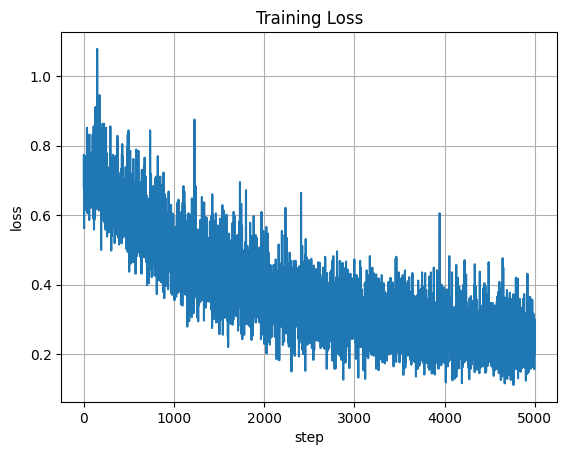

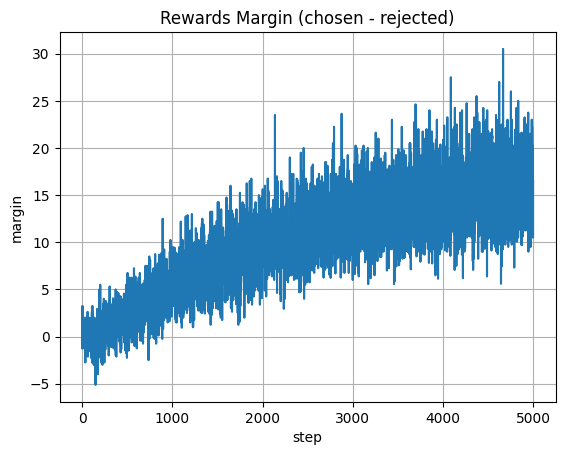

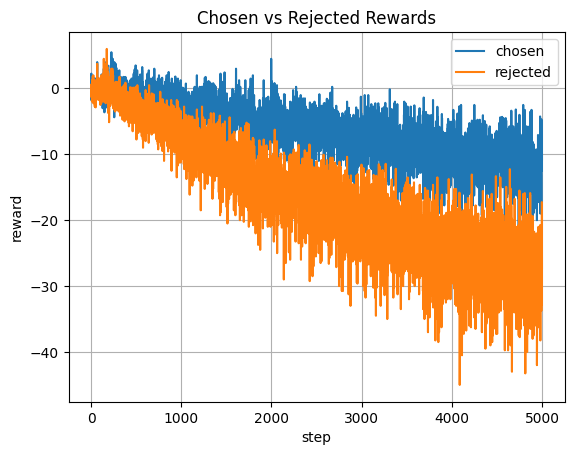

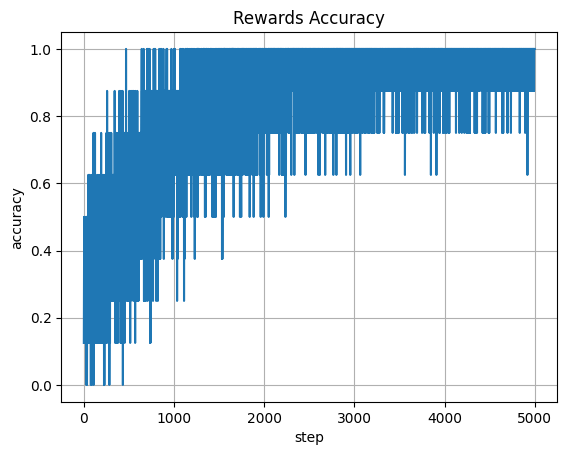

In [15]:
import types, json, os
import matplotlib.pyplot as plt
import numpy as np

# Keep metrics in-memory (and optionally save to disk)
INTERMEDIATE_CKPT_DIR = "/content/intermediate_ckpt_vlm"
os.makedirs(INTERMEDIATE_CKPT_DIR, exist_ok=True)
HIST_PATH  = os.path.join(INTERMEDIATE_CKPT_DIR, "train_history.json")

HISTORY = {
    "step": [],
    "loss": [],
    "chosen_rewards": [],
    "rejected_rewards": [],
    "rewards_margin": [],
    "rewards_accuracy": [],
}

# --- build trainer first ---
import optax
from tunix.sft.dpo.vl_dpo_trainer import VLM_DpoTrainer, VlmDpoTrainingConfig

MAX_STEPS  = 5000
BATCH_SIZE = 8
EPOCHS = 21

config = VlmDpoTrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    beta=BETA,
    label_smoothing=0.0,
    padding_value=gemma_tokenizer.pad_id(),
)
optimizer = optax.adamw(learning_rate=LEARNING_RATE)
train_batches = numpy_batches_vlm(ds, batch_size=BATCH_SIZE, shuffle=True, seed=42, epochs=EPOCHS)

with mesh:
    trainer = VLM_DpoTrainer(
        model=lora_gemma,
        ref_model=gemma3,
        optimizer=optimizer,
        training_config=config,
    )

    # --- patch AFTER trainer exists (bind to this instance) ---
    _orig_post = getattr(trainer, "_post_process_train_step", None)

    def _patched_post_process_train_step(self, aux):
        # keep original logging
        if _orig_post is not None:
            _orig_post(aux)

        s = int(getattr(self, "_train_steps", 0))

        # best-effort loss read
        loss_val = float("nan")
        bm = getattr(self, "_buffered_train_metrics", None)
        if bm is not None and getattr(bm, "losses", None):
            try:
                loss_val = float(bm.losses[-1])
            except Exception:
                pass

        HISTORY["step"].append(s)
        HISTORY["loss"].append(loss_val)
        HISTORY["chosen_rewards"].append(float(aux["chosen_rewards"]))
        HISTORY["rejected_rewards"].append(float(aux["rejected_rewards"]))
        HISTORY["rewards_margin"].append(float(aux["rewards_margin"]))
        HISTORY["rewards_accuracy"].append(float(aux["rewards_accuracy"]))

        # sanity ping every 10 steps so you know it’s firing
        if s % 10 == 0:
            print(f"[metric] step={s} loss={loss_val:.4f} margin={float(aux['rewards_margin']):.4f}")

    trainer._post_process_train_step = types.MethodType(_patched_post_process_train_step, trainer)
    print("✅ metrics capture patched on current trainer")

    # --- run training ---
    trainer.train(train_batches)

# optional: persist
with open(HIST_PATH, "w") as f:
    json.dump(HISTORY, f)
print("📈 history saved to:", HIST_PATH, "| points:", len(HISTORY["step"]))

# --- plotting ---
def _safe_xy(hist, key):
    x = np.array(hist.get("step", []), dtype=float)
    y = np.array(hist.get(key, []), dtype=float)
    return x, y

def _plot_series(x, y, title, ylabel):
    if len(x) == 0:
        print(f"[plot] no data for {title}")
        return
    plt.figure()
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel("step")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

x, y = _safe_xy(HISTORY, "loss")
_plot_series(x, y, "Training Loss", "loss")

x, y = _safe_xy(HISTORY, "rewards_margin")
_plot_series(x, y, "Rewards Margin (chosen - rejected)", "margin")

x, ch = _safe_xy(HISTORY, "chosen_rewards")
_, rj = _safe_xy(HISTORY, "rejected_rewards")
if len(x):
    plt.figure()
    plt.plot(x, ch, label="chosen")
    plt.plot(x, rj, label="rejected")
    plt.title("Chosen vs Rejected Rewards")
    plt.xlabel("step"); plt.ylabel("reward")
    plt.legend(); plt.grid(True); plt.show()

x, y = _safe_xy(HISTORY, "rewards_accuracy")
_plot_series(x, y, "Rewards Accuracy", "accuracy")